In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
import tmv_app.models as tm
import scoping.models as sm
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [3]:
speech_search_id = 83 #  old: 63
s = pm.Search.objects.get(id=speech_search_id) # speeches
print(pm.Utterance.objects.filter(search_matches=s).count())

pars_search_id = 81 # old: 69
#s = pm.Search.objects.get(id=pars_search_id) # paragraphs
#print(pm.Paragraph.objects.filter(search_matches=s).count())

9092


In [4]:
#s = None

if s:
    search_object_type = s.search_object_type
    name_str = str(s.id)
else:
    search_object_type = 2
    name_str = 'all'

9092
9092
9092


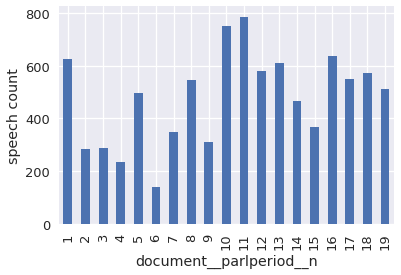

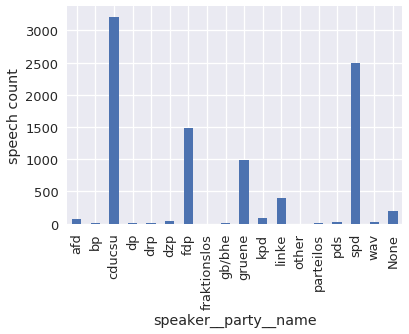

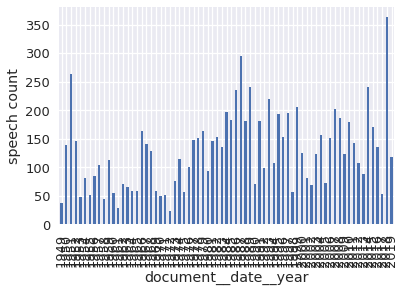

In [5]:
# show some statistics on document distribution

if search_object_type == 2:
    category_links = ['document__parlperiod__n', 'speaker__party__name', 'document__date__year']
else:
    category_links = ['utterance__document__parlperiod__n', 'utterance__speaker__party__name']


for category_link in category_links:
    if search_object_type == 2:
        if s:
            uts = pm.Utterance.objects.filter(search_matches=s)
        else:
            uts = pm.Utterance.objects.all()
        print(uts.count())
        counts = uts.values(category_link).annotate(count=Count('id')).order_by()
        ylabel = 'speech'
    else:
        if s:
            pars = pm.Paragraph.objects.filter(search_matches=s)
        else:
            pars = pm.Paragraph.objects.all()
        print(pars.count())
        counts = pars.values(category_link).annotate(count=Count('id')).order_by()
        ylabel = 'paragraph'

    # plot parliamentary period counts
    sns.set()
    sns.set_context("talk")
    df_counts = pd.DataFrame.from_dict(counts)
    df_counts = df_counts.set_index(category_link)
    if category_link == "document__date__year":
        df_counts = df_counts.sort_values(category_link)
    
    df_counts.plot(kind='bar', legend=False)
    
        # drop some of the labels:
    #df_party_counts = df_party_counts.drop(["fraktionslos", "parteilos", "pds", None])
    
    plt.xlabel(category_link)
    plt.ylabel(ylabel +  ' count')
    fig = plt.gcf()
    fig.savefig('./plots/topic_analysis/{}_{}_count_search_{}.png'.format(category_link, ylabel, name_str), dpi=300,  bbox_inches="tight")

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


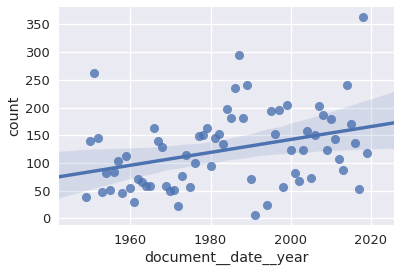

In [5]:
sns.regplot(x=category_link, y="count", data=df_counts.reset_index(), ci=99)

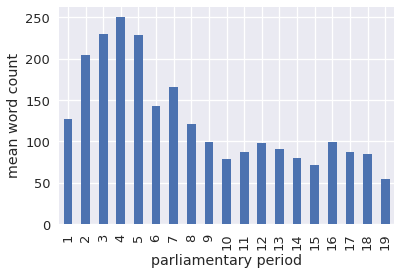

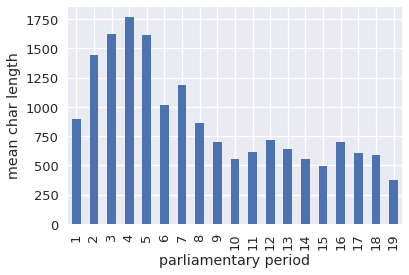

In [6]:
# statistics on mean length for paragraphs

if s:
    if search_object_type == 2:
        pars = pm.Paragraph.objects.filter(utterance__search_matches=s)
    else:
        pars = pm.Paragraph.objects.filter(search_matches=s)
else:
    pars = pm.Paragraph.objects.all()

# parlperiod
category_db_link = 'utterance__document__parlperiod__n'
category_name = 'parliamentary period'

# party
#category_db_link = 'utterance__speaker__party__name'
#category_name = 'party'

mean_length = pars.values(category_db_link).annotate(mean_wc=Avg('word_count'),
                                                                    mean_charlen=Avg('char_len')).order_by()

df_mean_length = pd.DataFrame.from_dict(mean_length)

df_mean_length = df_mean_length.set_index(category_db_link)
df_mean_length.plot(kind='bar', y='mean_wc', legend=False)
plt.xlabel(category_name)
plt.ylabel('mean word count')

df_mean_length.plot(kind='bar', y='mean_charlen', legend=False)
plt.xlabel(category_name)
plt.ylabel('mean char length')

#df_mean_length['mean_charlen'] / df_mean_length['mean_wc']

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


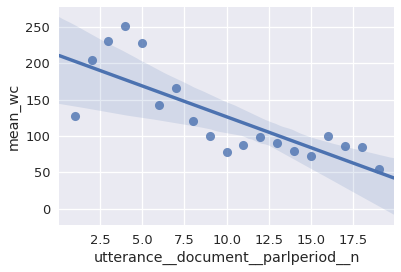

In [7]:
sns.regplot(x=category_db_link, y="mean_wc", data=df_mean_length.reset_index(), ci=99)

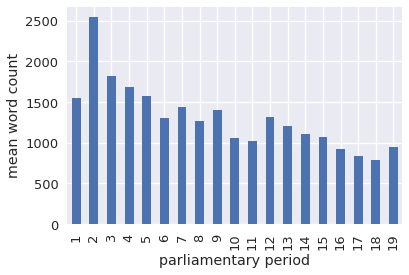

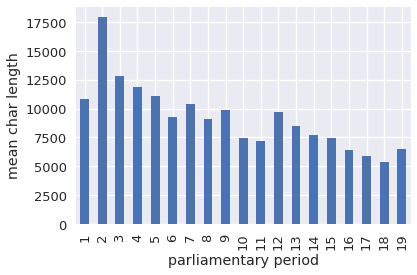

In [8]:
# statistics on length distribution for speeches

if s:
    if search_object_type == 2:
        uts = pm.Utterance.objects.filter(search_matches=s)
    else:
        uts = pm.Utterance.objects.filter(paragraph__search_matches=s)
else:
    uts = pm.Utterance.objects.all()

# parlperiod
category_db_link = 'document__parlperiod__n'
category_name = 'parliamentary period'

# party
#category_db_link = 'speaker__party__name'
#category_name = 'party'

ut_length = uts.values(category_db_link, 'id').annotate(sum_wc=Sum('paragraph__word_count'), sum_charlen=Sum('paragraph__char_len'))

df_ut_length = pd.DataFrame.from_dict(ut_length)

df_mean_length = df_ut_length.groupby(category_db_link).mean()

df_mean_length.plot(kind='bar', y='sum_wc', legend=False)
plt.xlabel(category_name)
plt.ylabel('mean word count')

df_mean_length.plot(kind='bar', y='sum_charlen', legend=False)
plt.xlabel(category_name)
plt.ylabel('mean char length')

#df_mean_length['sum_charlen'] / df_mean_length['sum_wc']

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


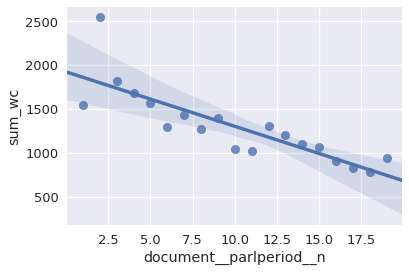

In [9]:
sns.regplot(x=category_db_link, y="sum_wc", data=df_mean_length.reset_index(), ci=99)